# The Battle of Neighborhoods - IBM Data Science Capstone Project

## Week 2

### 1. Import Libraries

In [429]:
import pandas as pd # library for data analysis
import numpy as np  # library for working with arrays

# Matplotlib and associated plotting modules
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# library to hanlde json files
import json

# to convert an address to latitudes and longitudes
from geopy.geocoders import Nominatim

# for extracting data from HTML files 
from bs4 import BeautifulSoup

# library to handle requests
import requests

# to transform json files to pandas dataframe
from pandas import json_normalize

# for visualizing geospatial data
import folium

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

### 2. Data Preprocessing

Let us create a table by importing the SIngapore coordinates data having Latitudes and Longitudes values

In [430]:
singapore_df = pd.read_csv('Singapore_coodinates.csv')
singapore_df.head()

,neighbourhood_group,neighbourhood,latitude,longitude
0,Central Region,Bishan,1.36000,103.83190
1,Central Region,Bukit Merah,1.27681,103.82381
2,Central Region,Bukit Timah,1.33235,103.78521
3,Central Region,Downtown Core,1.27663,103.84521
4,Central Region,Geylang,1.31698,103.89000


Let us find out how many neighborhoods within each group

In [431]:
singapore_df.groupby('neighbourhood_group').count()['neighbourhood']

neighbourhood_group
Central Region       19
East Region           4
North Region          6
North-East Region     5
West Region           9
Name: neighbourhood, dtype: int64

create a list of unique neighborhood groups

In [432]:
neighborhood_grps = singapore_df['neighbourhood_group'].unique().tolist()
neighborhood_grps

['Central Region',
 'East Region',
 'North Region',
 'North-East Region',
 'West Region']

In [558]:
groups_color = {}
for grp in neighborhood_grps:
    groups_color[grp] = '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

groups_color

{'Central Region': '#C793CF',
 'East Region': '#5EE785',
 'North Region': '#074482',
 'North-East Region': '#7A8CD2',
 'West Region': '#90269D'}

In [559]:
sing_lat = 1.3521
sing_lng = 103.8198

map_singapore = folium.Map(location=[sing_lat, sing_lng], zoom_start=11)

for lat, lng, group, neighborhood in zip(singapore_df['latitude'], singapore_df['longitude'], 
                                         singapore_df['neighbourhood_group'], singapore_df['neighbourhood']):
    label = folium.Popup(group + '/' + neighborhood)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        fill=True,
        popup=label,
        color=groups_color[group],
        fill_color=groups_color[group],
        fill_opacity=0.8).add_to(map_singapore)
    

map_singapore

### Define Foursquare Credentials and Version

In [435]:
CLIENT_ID = 'PK5KQQ4KQ1K33DQLABOWPVY1VA0GRFD4LEAUXECZ4MOYJW1U' # your Foursquare ID
CLIENT_SECRET = 'ZEQHN4AL13WB0Y1C3SA3ESIVORWM4EPANN50PRK1AFTODBBU' # your Foursquare Secret
ACCESS_TOKEN = 'ERZERBXUIXCREQXLJJ5YJRMGHKX0GECSL5I5F4CSO0RGCIJP' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PK5KQQ4KQ1K33DQLABOWPVY1VA0GRFD4LEAUXECZ4MOYJW1U
CLIENT_SECRET:ZEQHN4AL13WB0Y1C3SA3ESIVORWM4EPANN50PRK1AFTODBBU


## 3.1 Lets explore one of the neighborhoods

In [436]:
singapore_df.head()

,neighbourhood_group,neighbourhood,latitude,longitude
0,Central Region,Bishan,1.36000,103.83190
1,Central Region,Bukit Merah,1.27681,103.82381
2,Central Region,Bukit Timah,1.33235,103.78521
3,Central Region,Downtown Core,1.27663,103.84521
4,Central Region,Geylang,1.31698,103.89000


In [437]:
singapore_df.loc[singapore_df['neighbourhood'] == 'Bedok', 'latitude']

20    1.31313
Name: latitude, dtype: float64

In [438]:
neighborhood_lat = singapore_df.loc[20, 'latitude']
neighborhood_lng = singapore_df.loc[20, 'longitude']
neighborhood_name = singapore_df.loc[20, 'neighbourhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_lat, 
                                                               neighborhood_lng))

Latitude and longitude values of Bedok are 1.31313, 103.91479.


### let's get the top 100 venues that are in "Bedok" neighborhood within a radius of 500 meters

In [439]:
radius = 500

url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&oauth_token={}&ll={},{}&v={}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    ACCESS_TOKEN,
    neighborhood_lat,
    neighborhood_lng,
    VERSION,
    radius,
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?client_id=PK5KQQ4KQ1K33DQLABOWPVY1VA0GRFD4LEAUXECZ4MOYJW1U&client_secret=ZEQHN4AL13WB0Y1C3SA3ESIVORWM4EPANN50PRK1AFTODBBU&oauth_token=ERZERBXUIXCREQXLJJ5YJRMGHKX0GECSL5I5F4CSO0RGCIJP&ll=1.31313,103.91479&v=20180604&radius=500&limit=100'

In [440]:
results = requests.get(url).json()
results['response']['groups'][0].keys()

dict_keys(['type', 'name', 'items'])

In [441]:
bedok_venues = results['response']['groups'][0]['items']

bedok_nearby_venues = json_normalize(venues)
bedok_nearby_venues.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,...,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.neighborhood,venue.location.city,venue.location.crossStreet,venue.venuePage.id,venue.location.state
0,e-0-4f75a293e4b04262b6d646d7-0,0,"[{'summary': 'This spot is popular', 'type': '...",4f75a293e4b04262b6d646d7,Bruno's Bistrot,201 Telok Kurau Rd,1.312164,103.910925,"[{'label': 'display', 'lat': 1.312164286758040...",443,...,Singapore,"[201 Telok Kurau Rd, 423910]","[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",0,[],NaN,NaN,NaN,NaN,NaN
1,e-0-4c8105cad4e2370471835988-1,0,"[{'summary': 'This spot is popular', 'type': '...",4c8105cad4e2370471835988,818 Durians and Pastries,201 Telok Kurau Rd,1.312051,103.911074,"[{'label': 'display', 'lat': 1.312051238860812...",430,...,Singapore,"[201 Telok Kurau Rd, 423910]","[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",0,[],Bedok,Singapore,NaN,NaN,NaN
2,e-0-4b76b1a2f964a520db582ee3-2,0,"[{'summary': 'This spot is popular', 'type': '...",4b76b1a2f964a520db582ee3,Telok Kurau Park Basketball Court,NaN,1.315004,103.914566,"[{'label': 'display', 'lat': 1.315003965449119...",210,...,Singapore,NaN,"[{'id': '4bf58dd8d48988d1e1941735', 'name': 'B...",0,[],NaN,NaN,NaN,NaN,NaN
3,e-0-4cf9f3002d80a143baa141d8-3,0,"[{'summary': 'This spot is popular', 'type': '...",4cf9f3002d80a143baa141d8,Bus Stop 92141 (NAFA Arts Kindergarten),E Coast Rd,1.309408,103.914228,"[{'label': 'display', 'lat': 1.309407709228359...",419,...,Singapore,[E Coast Rd],"[{'id': '4bf58dd8d48988d1fe931735', 'name': 'B...",0,[],NaN,Singapore,NaN,NaN,NaN
4,e-0-4c02605c9a7920a1ed53ce79-4,0,"[{'summary': 'This spot is popular', 'type': '...",4c02605c9a7920a1ed53ce79,JK Don Cafe n Bar,Telok Kurau Rd,1.312101,103.910939,"[{'label': 'display', 'lat': 1.312101314525427...",443,...,Singapore,[Telok Kurau Rd],"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",0,[],NaN,Singapore,NaN,NaN,NaN


In [442]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
#     print(categories_list[0].keys())
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [443]:
filtered_cols = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
bedok_nearby_venues = bedok_nearby_venues.loc[:, filtered_cols]

In [444]:
bedok_nearby_venues['venue.categories'] = bedok_nearby_venues.apply(get_category_type, axis=1)

bedok_nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Bruno's Bistrot,Italian Restaurant,1.312164,103.910925
1,818 Durians and Pastries,Asian Restaurant,1.312051,103.911074
2,Telok Kurau Park Basketball Court,Basketball Court,1.315004,103.914566
3,Bus Stop 92141 (NAFA Arts Kindergarten),Bus Station,1.309408,103.914228
4,JK Don Cafe n Bar,Café,1.312101,103.910939


In [445]:
bedok_nearby_venues.columns = [col.split('.')[-1] for col in bedok_nearby_venues.columns]
print(bedok_nearby_venues.head())
print(bedok_nearby_venues.shape)

                                      name          categories       lat  \
0                          Bruno's Bistrot  Italian Restaurant  1.312164   
1                 818 Durians and Pastries    Asian Restaurant  1.312051   
2        Telok Kurau Park Basketball Court    Basketball Court  1.315004   
3  Bus Stop 92141 (NAFA Arts Kindergarten)         Bus Station  1.309408   
4                        JK Don Cafe n Bar                Café  1.312101   

          lng  
0  103.910925  
1  103.911074  
2  103.914566  
3  103.914228  
4  103.910939  
(9, 4)


## 3.2 Lets explore all the neighborhoods

In [446]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get venues for all neighborhoods in our dataset

In [447]:
singapore_venues = getNearbyVenues(names=singapore_df['neighbourhood'],
                                latitudes=singapore_df['latitude'],
                                longitudes=singapore_df['longitude'])

Bishan
Bukit Merah
Bukit Timah
Downtown Core
Geylang
Kallang
Marine Parade
Museum
Newton
Novena
Orchard
Outram
Queenstown
River Valley
Rochor
Singapore River
Southern Islands
Tanglin
Toa Payoh
Tampines
Bedok
Changi
Pasir Ris
Central Water Catchment
Mandai
Sembawang
Sungei Kadut
Woodlands
Yishun
Ang Mo Kio
Hougang
Punggol
Sengkang
Serangoon
Bukit Batok
Bukit Panjang
Choa Chu Kang
Clementi
Jurong East
Jurong West
Pioneer
Tuas
Western Water Catchment


In [448]:
singapore_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bishan,1.36,103.8319,Imperial Treasure Noodle House,1.359795,103.833834,Restaurant
1,Bishan,1.36,103.8319,Taste of Thailand (Original),1.357764,103.833689,Thai Restaurant
2,Bishan,1.36,103.8319,Rong Cheng (Sin Ming Rd) Bak Kut Teh 榕城(新民路)肉骨茶,1.359337,103.833823,Soup Place
3,Bishan,1.36,103.8319,Fork And Chopsticks,1.359834,103.833816,Asian Restaurant
4,Bishan,1.36,103.8319,Kopi Chwee Food Court,1.357786,103.833617,Food Court


In [449]:
singapore_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1168,Pioneer,1.31201,103.67881,Kopitiam,1.313381,103.678955,Coffee Shop
1169,Tuas,1.31800,103.64687,Jaya Shipbuilding,1.317400,103.647264,Harbor / Marina
1170,Tuas,1.31800,103.64687,Kwong soon Shipbuilding & Engineering,1.316635,103.647003,Boat or Ferry
1171,Tuas,1.31800,103.64687,H-192,1.317011,103.644884,Boat or Ferry
1172,Tuas,1.31800,103.64687,TUAS VILLAGE EATING HOUSE,1.319028,103.651000,Food Truck


#### How many venues per neighborhood

In [450]:
singapore_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ang Mo Kio,6,6,6,6,6,6
Bedok,7,7,7,7,7,7
Bishan,11,11,11,11,11,11
Bukit Batok,5,5,5,5,5,5
Bukit Merah,12,12,12,12,12,12
Bukit Panjang,31,31,31,31,31,31
Bukit Timah,11,11,11,11,11,11
Central Water Catchment,4,4,4,4,4,4
Changi,6,6,6,6,6,6


In [451]:
print("There are {} unique venue categories in total".format(len(singapore_venues['Venue Category'].unique())))

There are 204 unique venue categories in total


In [452]:
print("The venue categories are as below: ", '\n' , singapore_venues['Venue Category'].unique())

The venue categories are as below:  
 ['Restaurant' 'Thai Restaurant' 'Soup Place' 'Asian Restaurant'
 'Food Court' 'Bubble Tea Shop' 'Bus Station' 'Grocery Store'
 'Tennis Court' 'Coffee Shop' 'Café' 'Chinese Restaurant'
 'Vegetarian / Vegan Restaurant' 'Cosmetics Shop' 'Convenience Store'
 'Cafeteria' 'Italian Restaurant' 'Historic Site' 'Bus Stop'
 'Gym / Fitness Center' 'Bistro' 'Soccer Field' 'Dessert Shop' 'Bakery'
 'Hotel' 'Japanese Restaurant' 'Tapas Restaurant' 'Sushi Restaurant'
 'Bagel Shop' 'Bar' 'Kebab Restaurant' 'Cocktail Bar' 'BBQ Joint'
 'Spanish Restaurant' 'Ramen Restaurant' 'Salad Place' 'Bookstore'
 'Wine Bar' 'Noodle House' 'Korean Restaurant' 'Ice Cream Shop'
 'Yoga Studio' 'Tea Room' 'Dumpling Restaurant' 'Diner' 'Deli / Bodega'
 'Mosque' 'Burrito Place' 'Mexican Restaurant' 'Spa' 'Nightclub'
 'Sandwich Place' 'Music Venue' 'Discount Store' 'American Restaurant'
 'French Restaurant' 'Fast Food Restaurant' 'Cantonese Restaurant'
 'Basketball Court' 'Multiplex' 'F

In [453]:
### Are there any Thai restaurant in the venues?

"Thai Restaurant" in singapore_venues['Venue Category'].unique()

True

In [454]:
singapore_restaurants = singapore_venues[singapore_venues['Venue Category'].str.contains("Restaurant")].reset_index(drop=True)
singapore_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bishan,1.36000,103.83190,Imperial Treasure Noodle House,1.359795,103.833834,Restaurant
1,Bishan,1.36000,103.83190,Taste of Thailand (Original),1.357764,103.833689,Thai Restaurant
2,Bishan,1.36000,103.83190,Fork And Chopsticks,1.359834,103.833816,Asian Restaurant
3,Bukit Merah,1.27681,103.82381,Makko Teck Neo Pineapple Tarts,1.272906,103.822528,Chinese Restaurant
4,Bukit Merah,1.27681,103.82381,Nature Vegetarian Delights (Bukit Purmei) 大自然素食,1.274642,103.826471,Vegetarian / Vegan Restaurant
...,...,...,...,...,...,...,...
366,Choa Chu Kang,1.38768,103.74476,PastaMania,1.384646,103.745003,Italian Restaurant
367,Choa Chu Kang,1.38768,103.74476,Chippy @ lot one,1.384883,103.744701,Fast Food Restaurant
368,Clementi,1.29361,103.76746,Dario Pizza & More,1.292517,103.768233,Italian Restaurant
369,Clementi,1.29361,103.76746,Hot & Spicy Nasi Lemak Family Restaurant,1.292208,103.768348,Malay Restaurant


In [455]:
grp_restaurants = pd.merge(singapore_df, 
                           singapore_restaurants,
                           how='inner', 
                           left_on=['neighbourhood'], 
                           right_on=['Neighborhood'])[['neighbourhood_group', 'Venue Category']]
grp_restaurants.head()

,neighbourhood_group,Venue Category
0,Central Region,Restaurant
1,Central Region,Thai Restaurant
2,Central Region,Asian Restaurant
3,Central Region,Chinese Restaurant
4,Central Region,Vegetarian / Vegan Restaurant


In [456]:
group_count_df = grp_restaurants.groupby(['neighbourhood_group'])['Venue Category'].agg('count').to_frame('Restaurant Counts').reset_index()
group_count_df

,neighbourhood_group,Restaurant Counts
0,Central Region,309
1,East Region,7
2,North Region,15
3,North-East Region,18
4,West Region,22


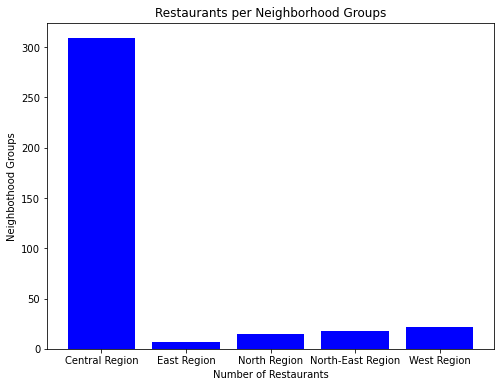

In [549]:
%matplotlib inline

plt.figure(figsize=(8,6))

plt.bar(group_count_df['neighbourhood_group'], group_count_df['Restaurant Counts'], color='blue')
plt.xlabel('Number of Restaurants')
plt.ylabel('Neighbothood Groups')
plt.title('Restaurants per Neighborhood Groups')


plt.show()


Clearly, Central Region has most number of Restaurants compared to all other regions

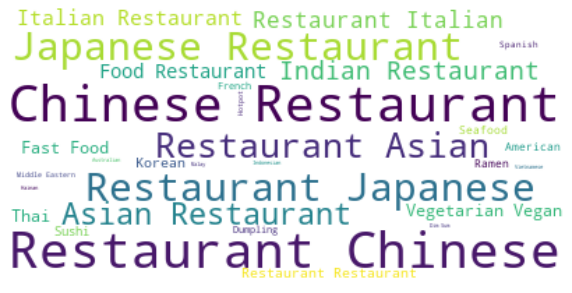

In [458]:
from wordcloud import WordCloud

plt.figure(figsize=(10, 8))

wordlist = ' '.join(grp_restaurants['Venue Category'])
wordcloud = WordCloud(background_color = 'white').generate(wordlist)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

By the wordcloud map, it is clear that Chinese & Japanase cuisine restaurants are in most number

## 4. Data Analysis

#### One hot encoding

In [459]:
singapore_onehot = pd.get_dummies(singapore_restaurants[['Venue Category']], prefix="", prefix_sep="")

singapore_onehot['Neighborhood'] = singapore_restaurants['Neighborhood']

fixed_columns = [singapore_onehot.columns[-1]] + list(singapore_onehot.columns[:-1])
singapore_onehot = singapore_onehot[fixed_columns]

print(singapore_onehot.shape)
singapore_onehot.head()

(371, 41)


,Neighborhood,American Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Fast Food Restaurant,...,Shabu-Shabu Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bishan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bishan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Bishan,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bukit Merah,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bukit Merah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [460]:
singapore_grouped = singapore_onehot.groupby(['Neighborhood']).mean().reset_index()

print(singapore_grouped.shape)
singapore_grouped.head()

(33, 41)


,Neighborhood,American Restaurant,Asian Restaurant,Australian Restaurant,Cantonese Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Fast Food Restaurant,...,Shabu-Shabu Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Ang Mo Kio,0.0,0.000000,0.0,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Bedok,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,Bishan,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0
3,Bukit Merah,0.0,0.000000,0.0,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0.0
4,Bukit Panjang,0.0,0.000000,0.0,0.0,0.4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0


## 5. Lets analyze which is the best neighborhood to open a Thai Restaurant

In [461]:
thai = singapore_grouped[['Neighborhood', 'Thai Restaurant']]
thai.shape

(33, 2)

### 5.1 Find the optimal K value

In [462]:
X = thai.drop(['Neighborhood'], axis=1)

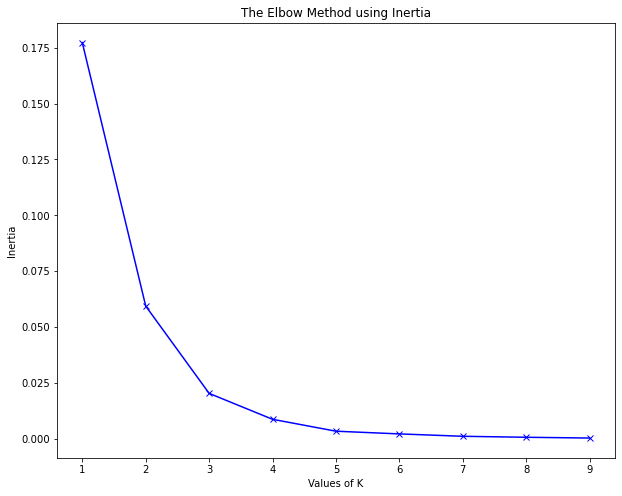

In [463]:
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
    
plt.figure(figsize=(10, 8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 4.

### Run K-means clustering with k=4

In [464]:
k = 4

singapore_grp_clust = thai.drop('Neighborhood', axis=1)

kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(singapore_grp_clust)

# list out all the cluster labels generated
kmeans.labels_

array([0, 0, 2, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 1, 3, 0, 0, 0,
       0, 1, 0, 3, 3, 0, 0, 0, 0, 0, 1])

In [465]:
### Add cluster label columns to our dataset

thai.insert(0, 'Cluster Labels', kmeans.labels_)
thai.head()
thai.shape

(33, 3)

In [466]:
singapore_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bishan,1.36000,103.83190,Imperial Treasure Noodle House,1.359795,103.833834,Restaurant
1,Bishan,1.36000,103.83190,Taste of Thailand (Original),1.357764,103.833689,Thai Restaurant
2,Bishan,1.36000,103.83190,Fork And Chopsticks,1.359834,103.833816,Asian Restaurant
3,Bukit Merah,1.27681,103.82381,Makko Teck Neo Pineapple Tarts,1.272906,103.822528,Chinese Restaurant
4,Bukit Merah,1.27681,103.82381,Nature Vegetarian Delights (Bukit Purmei) 大自然素食,1.274642,103.826471,Vegetarian / Vegan Restaurant


In [467]:
thai_merged = pd.merge(thai, singapore_restaurants, 
                       how='left', left_on=['Neighborhood'], right_on=['Neighborhood'])[['Cluster Labels', 'Neighborhood',
                                                                                        'Neighborhood Latitude',
                                                                                        'Neighborhood Longitude',
                                                                                        'Venue', 'Venue Category',
                                                                                        'Thai Restaurant']]

thai_merged.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Thai Restaurant
0,0,Ang Mo Kio,1.39088,103.85303,Stewhaus,Restaurant,0.000000
1,0,Ang Mo Kio,1.39088,103.85303,Wong Feng Guan Eating House,Chinese Restaurant,0.000000
2,0,Bedok,1.31313,103.91479,Bruno's Bistrot,Italian Restaurant,0.000000
3,0,Bedok,1.31313,103.91479,818 Durians and Pastries,Asian Restaurant,0.000000
4,2,Bishan,1.36000,103.83190,Imperial Treasure Noodle House,Restaurant,0.333333


In [468]:
print("There are {} Thai restaurants in total".format(thai_merged[thai_merged['Venue Category'] == 'Thai Restaurant'].shape[0]))

There are 18 Thai restaurants in total


In [473]:
import matplotlib.cm as cm
import matplotlib.colors as colors

sing_lat = 1.3521
sing_lng = 103.8198

map_singapore = folium.Map(location=[sing_lat, sing_lng], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(thai_merged['Neighborhood Latitude'], thai_merged['Neighborhood Longitude'], 
                                  thai_merged['Neighborhood'], thai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_singapore)


map_singapore

In [564]:
thai.head(10)

,Cluster Labels,Neighborhood,Thai Restaurant
0,0,Ang Mo Kio,0.000000
1,0,Bedok,0.000000
2,2,Bishan,0.333333
3,0,Bukit Merah,0.000000
4,3,Bukit Panjang,0.100000
5,0,Bukit Timah,0.000000
6,3,Choa Chu Kang,0.111111
7,0,Clementi,0.000000
8,3,Downtown Core,0.046512
9,0,Geylang,0.000000


## Cluster 1 records

In [523]:
cluster1 = thai_merged[thai_merged['Cluster Labels'] == 0]
cluster1.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Thai Restaurant
0,0,Ang Mo Kio,1.39088,103.85303,Stewhaus,Restaurant,0.0
1,0,Ang Mo Kio,1.39088,103.85303,Wong Feng Guan Eating House,Chinese Restaurant,0.0
2,0,Bedok,1.31313,103.91479,Bruno's Bistrot,Italian Restaurant,0.0
3,0,Bedok,1.31313,103.91479,818 Durians and Pastries,Asian Restaurant,0.0
7,0,Bukit Merah,1.27681,103.82381,Makko Teck Neo Pineapple Tarts,Chinese Restaurant,0.0


## Cluster 2 records

In [524]:
cluster2 = thai_merged[thai_merged['Cluster Labels'] == 1]
cluster2.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Thai Restaurant
192,1,Novena,1.31327,103.8398,Heng Carrot Cake,Asian Restaurant,0.125
193,1,Novena,1.31327,103.8398,Bangkok Express,Thai Restaurant,0.125
194,1,Novena,1.31327,103.8398,Li Bai Cantonese Restaurant,Chinese Restaurant,0.125
195,1,Novena,1.31327,103.8398,Chui Huay Lim Teochew Cuisine,Chinese Restaurant,0.125
196,1,Novena,1.31327,103.8398,Alliance Seafood,Seafood Restaurant,0.125


## Cluster 3 records

In [535]:
cluster3 = thai_merged[thai_merged['Cluster Labels'] == 2]
cluster3.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Thai Restaurant
4,2,Bishan,1.36,103.8319,Imperial Treasure Noodle House,Restaurant,0.333333
5,2,Bishan,1.36,103.8319,Taste of Thailand (Original),Thai Restaurant,0.333333
6,2,Bishan,1.36,103.8319,Fork And Chopsticks,Asian Restaurant,0.333333


## Cluster 4 records

In [534]:
cluster4 = thai_merged[thai_merged['Cluster Labels'] == 3]
cluster4.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Thai Restaurant
9,3,Bukit Panjang,1.3471,103.77532,Al-Azhar Eating Restaurant ال اذحار (Al-Azhar ...,Indian Restaurant,0.1
10,3,Bukit Panjang,1.3471,103.77532,Sin Manbok,Korean Restaurant,0.1
11,3,Bukit Panjang,1.3471,103.77532,Joo Seng Teochew Porridge & Rice,Chinese Restaurant,0.1
12,3,Bukit Panjang,1.3471,103.77532,G7 Sinma Live Bull Frog Claypot Porridge G7新馬砂...,Chinese Restaurant,0.1
13,3,Bukit Panjang,1.3471,103.77532,Ga Ya Guem Korean Family Restaurant,Korean Restaurant,0.1


In [536]:
cluster_means = [cluster1['Thai Restaurant'].mean(), 
                cluster2['Thai Restaurant'].mean(),
                cluster3['Thai Restaurant'].mean(),
                cluster4['Thai Restaurant'].mean()]

cluster_means

[0.010752688172043022,
 0.16129032258064516,
 0.3333333333333333,
 0.06622516556291383]

In [541]:
thai['Cluster Labels'].value_counts()

0    21
3     8
1     3
2     1
Name: Cluster Labels, dtype: int64

In [542]:
clusters = np.arange(1,k+1).tolist()
print(clusters)
neighborhood_counts = thai['Cluster Labels'].value_counts().sort_index(ascending=True).tolist()
print(neighborhood_counts)

[1, 2, 3, 4]
[21, 3, 1, 8]


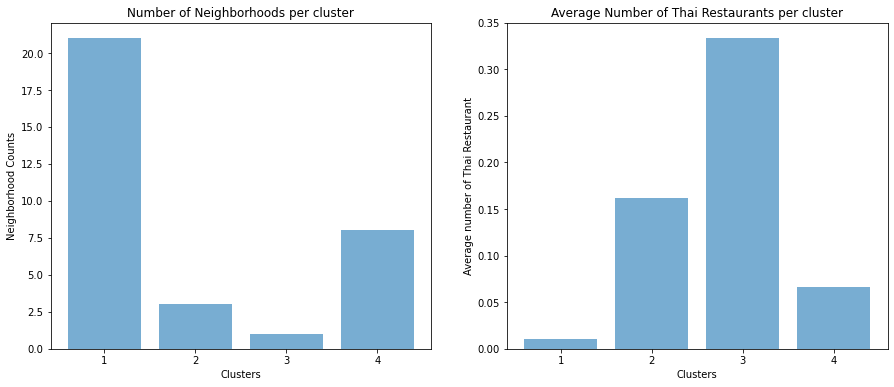

In [547]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.bar(clusters, neighborhood_counts, alpha=0.6, )
plt.xticks(clusters)
plt.xlabel("Clusters")
plt.ylabel("Neighborhood Counts")
plt.title("Number of Neighborhoods per cluster")

plt.subplot(1,2,2)
plt.bar(clusters, cluster_means, alpha=0.6, )
plt.xticks(clusters)
plt.xlabel("Clusters")
plt.ylabel("Average number of Thai Restaurant")
plt.title("Average Number of Thai Restaurants per cluster")

plt.show()

In [566]:
cluster1['Neighborhood'].unique()

array(['Ang Mo Kio', 'Bedok', 'Bukit Merah', 'Bukit Timah', 'Clementi',
       'Geylang', 'Hougang', 'Jurong West', 'Kallang', 'Mandai',
       'Marine Parade', 'Outram', 'Pasir Ris', 'Punggol', 'Queenstown',
       'Rochor', 'Southern Islands', 'Tampines', 'Tanglin', 'Toa Payoh',
       'Woodlands'], dtype=object)

In [565]:
cluster4['Neighborhood'].unique()

array(['Bukit Panjang', 'Choa Chu Kang', 'Downtown Core', 'Museum',
       'Newton', 'Orchard', 'Serangoon', 'Singapore River'], dtype=object)

## 6. Conclusion

Based on our analysis, cluster 1 & 4 is having more number of neighborhoods. But the number of Thai restaurants in both the clusters are very less.
So neighborhoods coming under these 2 clusters are favourable for opening a Thai cuisine restaurant. Whereas, the number of neighborhoods in cluster 3 are low 
and the number of Thai restaurants are way more compared to other clusters. So the neihborhoods in this cluster will have high competition andis risky to open a Thai restaurant.
